In [1]:
import sys
sys.path.append('/home/jbourbeau/cr-composition')
sys.path

['',
 '/cvmfs/icecube.opensciencegrid.org/py2-v1/RHEL_6_x86_64/lib/python2.7/site-packages/setuptools-15.2-py2.7.egg',
 '/cvmfs/icecube.opensciencegrid.org/py2-v1/RHEL_6_x86_64/lib/python2.7/site-packages/setuptools-15.2-py2.7.egg',
 '/home/jbourbeau/.local/lib/python2.7/site-packages',
 '/cvmfs/icecube.opensciencegrid.org/py2-v1/RHEL_6_x86_64/i3ports/root-v5.34.18/lib',
 '/cvmfs/icecube.opensciencegrid.org/py2-v1/RHEL_6_x86_64/lib/python2.7/site-packages',
 '/cvmfs/icecube.opensciencegrid.org/py2-v1/RHEL_6_x86_64/i3ports/lib/python2.7/site-packages',
 '/data/user/jbourbeau/metaprojects/icerec/V05-00-00/build/lib',
 '/home/jbourbeau/cr-composition/analysis',
 '/home/jbourbeau',
 '/home/jbourbeau/useful',
 '/home/jbourbeau/anisotropy',
 '/home/jbourbeau/ShowerLLH_scripts',
 '/cvmfs/icecube.opensciencegrid.org/py2-v1/RHEL_6_x86_64/lib/python27.zip',
 '/cvmfs/icecube.opensciencegrid.org/py2-v1/RHEL_6_x86_64/lib/python2.7',
 '/cvmfs/icecube.opensciencegrid.org/py2-v1/RHEL_6_x86_64/lib/pyth

In [2]:
import numpy as np
import sys
import matplotlib.pyplot as plt
import seaborn.apionly as sns

# from composition.analysis.load_sim import load_sim
# from composition.support_functions.checkdir import checkdir
# import composition.analysis.plotting_functions as plotting

import composition as comp

%matplotlib inline

/home/jbourbeau/.local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [5]:
def make_charge_energy_histogram(log_energy, charge, proton_mask, iron_mask, ax, plot_line=False, xlabel=None):
#     charge_bins = np.linspace(0, 6, 50)
#     energy_bins = np.arange(6.2, 8.0, 0.05)
    charge_bins = 50
    energy_bins = 50
#     energy_bins = np.arange(6.2, 9.51, 0.05)
#     energy_midpoints = (energy_bins[1:] + energy_bins[:-1]) / 2
    proton_hist, xedges, yedges = np.histogram2d(log_energy[MC_proton_mask],
                                                 charge[MC_proton_mask],
                                                 bins=[energy_bins,
                                                       charge_bins],
                                                 normed=False)
    proton_hist = np.ma.masked_where(proton_hist == 0, proton_hist)
    iron_hist, xedges, yedges = np.histogram2d(log_energy[MC_iron_mask],
                                               charge[MC_iron_mask],
                                               bins=[energy_bins, charge_bins],
                                               normed=False)

    h = proton_hist / (proton_hist + iron_hist)
    h = np.rot90(h)
    h = np.flipud(h)
    h = np.ma.masked_where(h == 0, h)
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    
    def line_fit(array):
        fit = []
        for x in array:
            if x <= 9.0:
                slope = (5.3 - 2.55) / (9.5 - 6.2)
                fit.append(2.55 + slope * (x - 6.2))
            else:
                slope = (5.20 - 4.9) / (9.5 - 9.0)
                fit.append(4.9 + slope * (x - 9.0))
        fit = np.array(fit)
        return fit

    colormap = 'coolwarm'
    im = ax.imshow(h, extent=extent, origin='lower',
               interpolation='none', cmap=colormap,
               aspect='auto', vmin=0, vmax=1)
    x = np.arange(6.2, 9.51, 0.1)
    if plot_line:
        ax.plot(x, line_fit(x), marker='None', linestyle='--',
                 color='k')
    if xlabel:
        ax.set_xlabel(xlabel)
        
    return im


number of events = 51608
[ 3.07516428  3.72994781  3.57956563 ...,  3.37126456  3.49191583
  3.76607233]
number of events = 51608
[ 3.05199001  3.29512616  3.57923469 ...,  3.34636361  3.25642122
  3.74266896]
number of events = 51589
[ 2.87058932  2.99652415  3.563019   ...,  3.1459832   2.8936624
  3.52259777]
number of events = 50592
[ 2.45170768  2.57714624  3.04401777 ...,  2.7257533   2.50205533
  2.82064943]


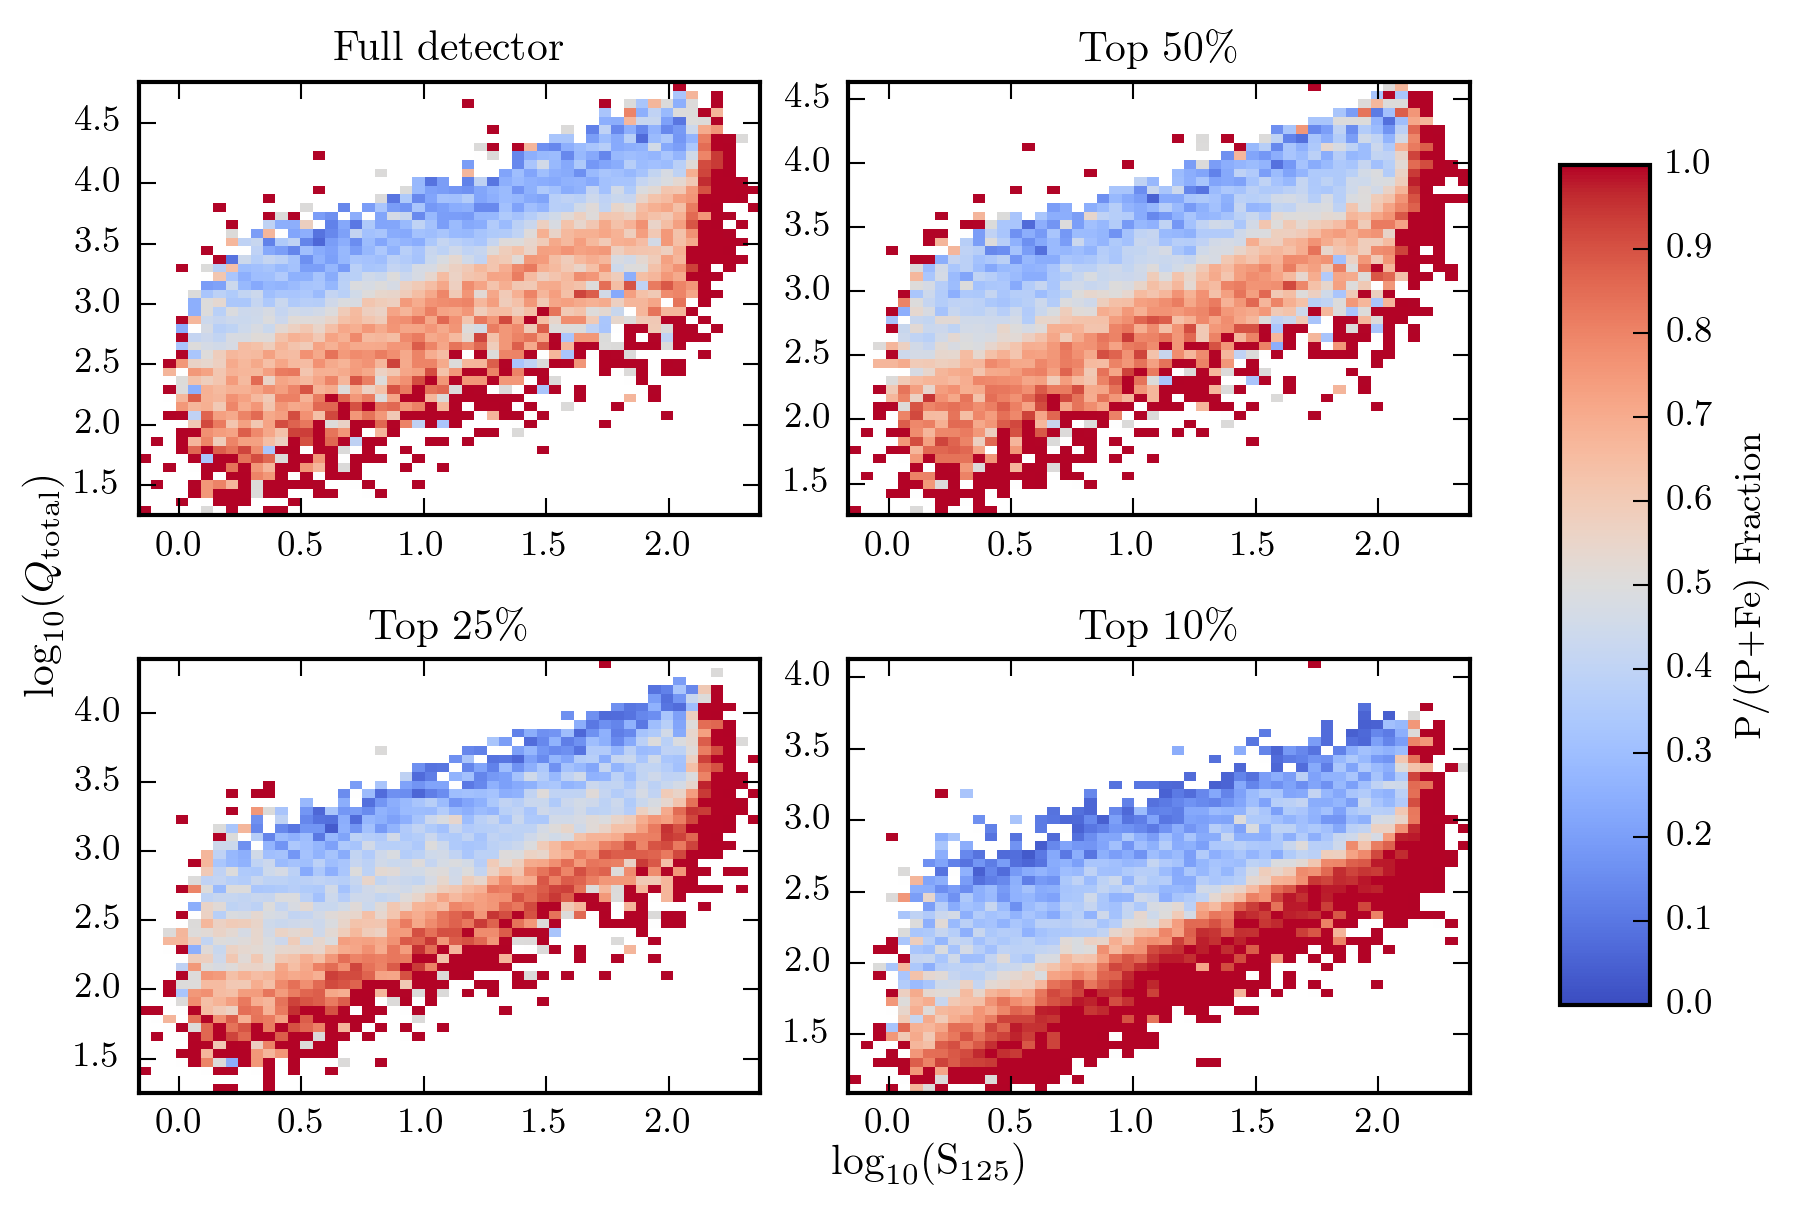

In [8]:
# charge_list = ['_1_60','_1_45', '_1_30', '_1_15']
# title_list = ['Full detector','Top 75\%', 'Top 50\%', 'Top 25\%']

charge_list = ['_1_60','_1_30', '_1_15', '_1_6']
title_list = ['Full detector','Top 50\%', 'Top 25\%', 'Top 10\%']

fig, axarr = plt.subplots(2,2)
for charge, title, ax in zip(charge_list, title_list, axarr.flatten()):
    # Import ShowerLLH sim reconstructions and cuts to be made
    df, cut_dict = comp.load_sim(return_cut_dict=True)
    selection_mask = np.array([True] * len(df))
    standard_cut_keys = ['LLHlap_reco_exists', 'LLHlap_zenith', 'NStations', 'IT_signal',
                         'StationDensity', 'LLHlap_containment', 'energy_range']
    for key in standard_cut_keys:
        selection_mask *= cut_dict[key]
    
#     selection_mask *= (df['LLHlap_InIce_containment'] < 1.0)
    selection_mask *= cut_dict['NChannels' + charge]
    selection_mask *= cut_dict['max_qfrac' + charge]
#     selection_mask *= (df['max_charge_frac{}'.format(charge)] < 0.3)
    df = df[selection_mask]
    print('number of events = {}'.format(len(df)))

    MC_proton_mask = (df.MC_comp == 'P')
    MC_iron_mask = (df.MC_comp == 'Fe')
    log_energy = df['reco_log_energy']
    log_energy = df['log_s125']
    charge = np.log10(df['InIce_charge{}'.format(charge)])
    im = make_charge_energy_histogram(log_energy, charge, MC_proton_mask, MC_iron_mask, ax=ax)
    print(charge.values)
    ax.set_title(title)

fig.text(0.5, 0.00, '$\log_{10}(\mathrm{S}_{125})$', ha='center')
# fig.text(0.5, 0.00, '$\log_{10}(E_{\mathrm{reco}}/\mathrm{GeV})$', ha='center')
fig.text(0.00, 0.5, '$\log_{10}(Q_{\mathrm{total}})$', va='center', rotation='vertical')
plt.tight_layout()
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax, label='P/(P+Fe) Fraction')
# plt.colorbar(im, label='P/(P+Fe) Fraction')

In [2]:
from pandas.tools.plotting import parallel_coordinates